In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import holidays

#### Number of records and attributes

In [ ]:
## read data
data = pd.read_csv('orders_train.txt', sep=';')
print('Number of records between {} to {}: {}'.format(data['orderDate'].iloc[0], data['orderDate'].iloc[-1], len(data)))
print('Number of attributes corresponding to a single record {}:'.format(data.shape[1]-1))
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of records between 2014-01-01 to 2014-03-26: 248333
Number of attributes corresponding to a single record 14:


,orderID,orderDate,articleID,colorCode,sizeCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,deviceID,paymentMethod,returnQuantity
0,a1000001,2014-01-01,i1000382,1972,44,3.0,1,10.00,29.99,0,0.0,c1010575,2,BPRG,0
1,a1000001,2014-01-01,i1000550,3854,44,3.0,1,20.00,39.99,0,0.0,c1010575,2,BPRG,0
2,a1000002,2014-01-01,i1001991,2974,38,8.0,1,35.00,49.99,0,0.0,c1045905,4,BPRG,0
3,a1000002,2014-01-01,i1001999,1992,38,8.0,1,49.99,49.99,0,0.0,c1045905,4,BPRG,1
4,a1000003,2014-01-01,i1001942,1968,42,8.0,1,10.00,35.99,0,0.0,c1089295,2,PAYPALVC,0


#### Data types and statistics

In [ ]:
print(data.info())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248333 entries, 0 to 248332
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   orderID         248333 non-null  object 
 1   orderDate       248333 non-null  object 
 2   articleID       248333 non-null  object 
 3   colorCode       248333 non-null  int64  
 4   sizeCode        248333 non-null  object 
 5   productGroup    248298 non-null  float64
 6   quantity        248333 non-null  int64  
 7   price           248333 non-null  float64
 8   rrp             248298 non-null  float64
 9   voucherID       248331 non-null  object 
 10  voucherAmount   248333 non-null  float64
 11  customerID      248333 non-null  object 
 12  deviceID        248333 non-null  int64  
 13  paymentMethod   248333 non-null  object 
 14  returnQuantity  248333 non-null  int64  
dtypes: float64(4), int64(4), object(7)
memory usage: 28.4+ MB
None


#### Missing values and inconsistent records

In [ ]:
#check NA values
print(data.isna().sum())
#drop NA values since not a significant number of records contain NA
data = data.dropna()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


orderID            0
orderDate          0
articleID          0
colorCode          0
sizeCode           0
productGroup      35
quantity           0
price              0
rrp               35
voucherID          2
voucherAmount      0
customerID         0
deviceID           0
paymentMethod      0
returnQuantity     0
dtype: int64


In [ ]:
## inconsistent records
drop_idx = data[(data['quantity']==0) |  (data['price']==0) | (data['quantity']<data['returnQuantity']) ].index
data = data.drop(drop_idx)
data.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(243621, 15)

### Most Returned Articles

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-6-bcce43ec3a81>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=most_returned, x='articleID', y='returnQuantity', palette='coolwarm')
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype,

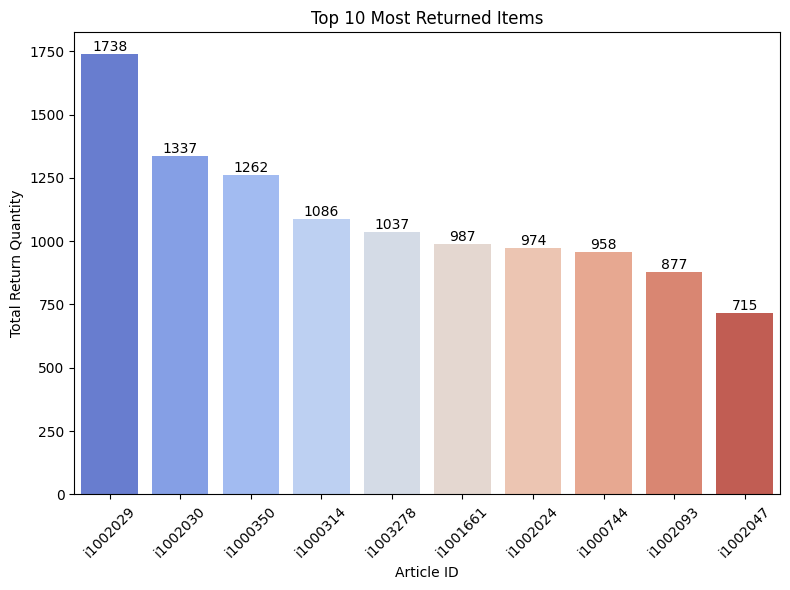

In [ ]:
# Group by articleID and sum returnQuantity, then get the top 10 most returned items
most_returned = data.groupby('articleID')['returnQuantity'].sum().nlargest(10).reset_index()
# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=most_returned, x='articleID', y='returnQuantity', palette='coolwarm')
for index, row in most_returned.iterrows():
    plt.text(row.name, row.returnQuantity, str(row.returnQuantity), ha='center', va='bottom', fontsize=10)

plt.xlabel('Article ID')
plt.ylabel('Total Return Quantity')
plt.title('Top 10 Most Returned Items')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# plt.savefig('top_10_returned_items.png')

### Common Attributes among most Returned Articles

In [ ]:
top_returned_details = data.merge(most_returned, on='articleID')
common_color = top_returned_details['colorCode'].mode()[0]

# Similarly, for sizeCode and productGroup:
common_size = top_returned_details['sizeCode'].mode()[0]
common_product_group = top_returned_details['productGroup'].mode()[0]
common_price = top_returned_details['price'].mode()[0]
common_rrp = top_returned_details['rrp'].mode()[0]
print(f"Most common color code: {common_color}")
print(f"Most common size code: {common_size}")
print(f"Most common product group: {common_product_group}")
print(f"Most common price: {common_price}")
print(f"Most common recommended retail price (rrp): {common_rrp}")


Most common color code: 1002
Most common size code: 42
Most common product group: 3.0
Most common price: 39.99
Most common recommended retail price (rrp): 39.99


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


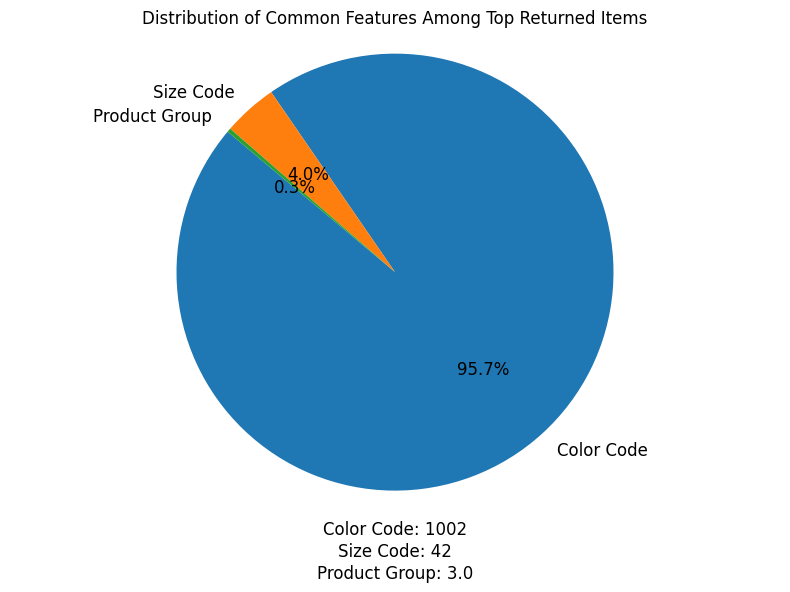

In [ ]:
#dictionary with common features
common_features = {
    'Color Code': common_color,
    'Size Code': common_size,
    'Product Group': common_product_group,
}
common_features = {k: v for k, v in common_features.items() if v is not None}

# pie chart
plt.figure(figsize=(8, 6))
pie = plt.pie(common_features.values(), labels=common_features.keys(), autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
plt.axis('equal')
plt.title('Distribution of Common Features Among Top Returned Items')
for i, (feature, value) in enumerate(common_features.items()):
    plt.text(0, -1.2 - 0.1 * i, f"{feature}: {value}", ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('distribution_of_common_fea.png')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


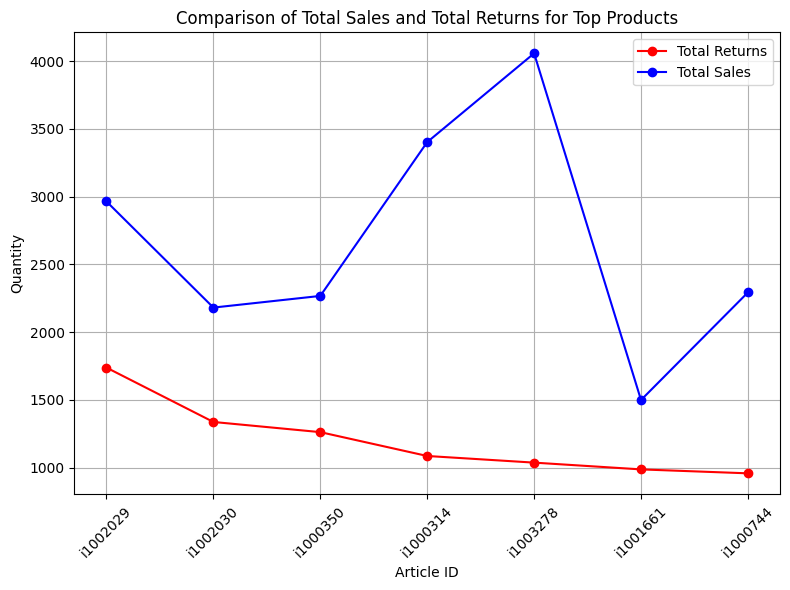

In [ ]:
most_returned = data.groupby('articleID')['returnQuantity'].sum().nlargest(10).reset_index()
most_sold = data.groupby('articleID')['quantity'].sum().nlargest(10).reset_index()
combined_data = most_returned.merge(most_sold, on='articleID', suffixes=('_returned', '_sold'))
plt.figure(figsize=(8, 6))
plt.plot(combined_data['articleID'], combined_data['returnQuantity'], marker='o', color='red', linestyle='-', label='Total Returns')
plt.plot(combined_data['articleID'], combined_data['quantity'], marker='o', color='blue', linestyle='-', label='Total Sales')
plt.xlabel('Article ID')
plt.ylabel('Quantity')
plt.title('Comparison of Total Sales and Total Returns for Top Products')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

### Return Anlaysis over the weekend and holidays

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

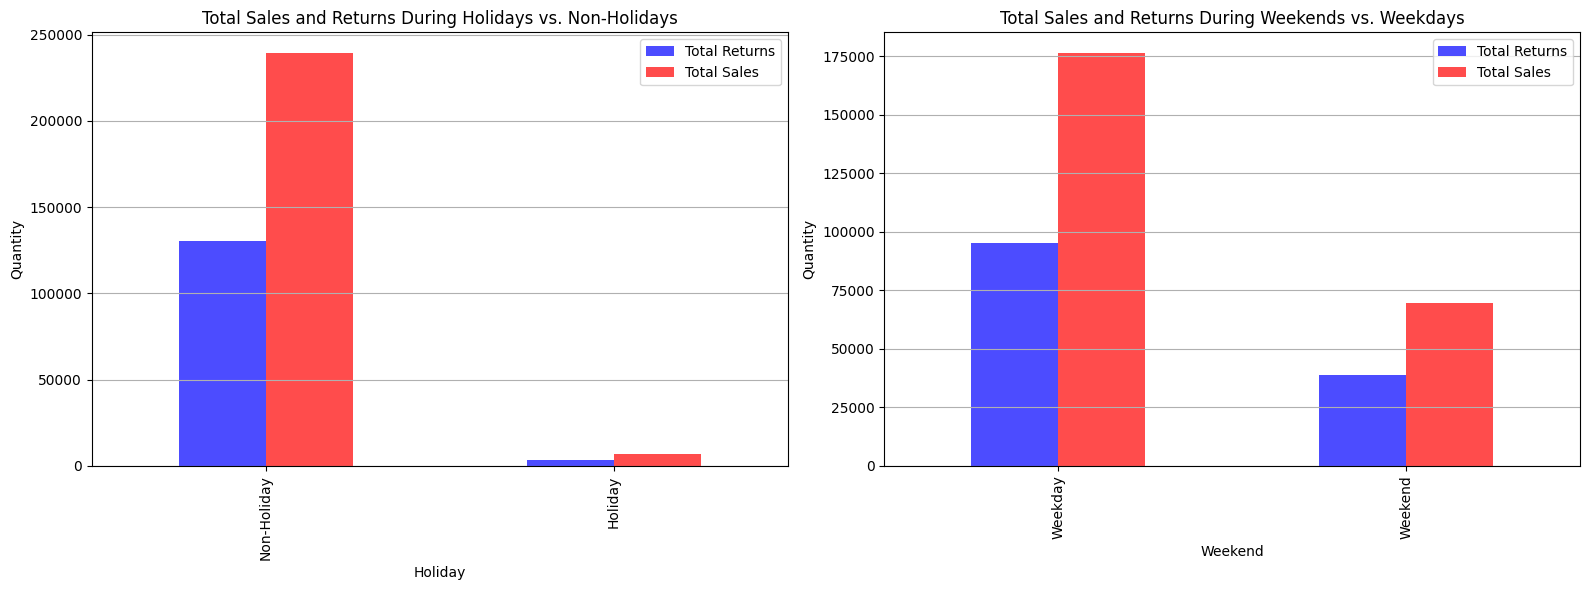

In [ ]:
df = data.copy()
df['orderDate'] = pd.to_datetime(df['orderDate'])
df['is_weekend'] = df['orderDate'].dt.dayofweek.isin([5, 6])

us_holidays = holidays.US(years=df['orderDate'].dt.year.unique())
df['is_holiday'] = df['orderDate'].dt.date.isin(us_holidays)

holiday_sales_returns = df.groupby('is_holiday')[['returnQuantity', 'quantity']].sum()
weekend_sales_returns = df.groupby('is_weekend')[['returnQuantity', 'quantity']].sum()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

holiday_sales_returns.plot(kind='bar', color=['blue', 'red'], alpha=0.7, ax=axes[0])
axes[0].set_xlabel('Holiday')
axes[0].set_ylabel('Quantity')
axes[0].set_title('Total Sales and Returns During Holidays vs. Non-Holidays')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Non-Holiday', 'Holiday'])
axes[0].legend(['Total Returns', 'Total Sales'])
axes[0].grid(axis='y')
weekend_sales_returns.plot(kind='bar', color=['blue', 'red'], alpha=0.7, ax=axes[1])
axes[1].set_xlabel('Weekend')
axes[1].set_ylabel('Quantity')
axes[1].set_title('Total Sales and Returns During Weekends vs. Weekdays')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Weekday', 'Weekend'])
axes[1].legend(['Total Returns','Total Sales'])
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()
# plt.savefig('holidays_weekends.png',dpi=200)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/c_parser_wrapper.py:373: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common_type = np.find_common_type(
/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/c_parser_wrapper.py:373: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.

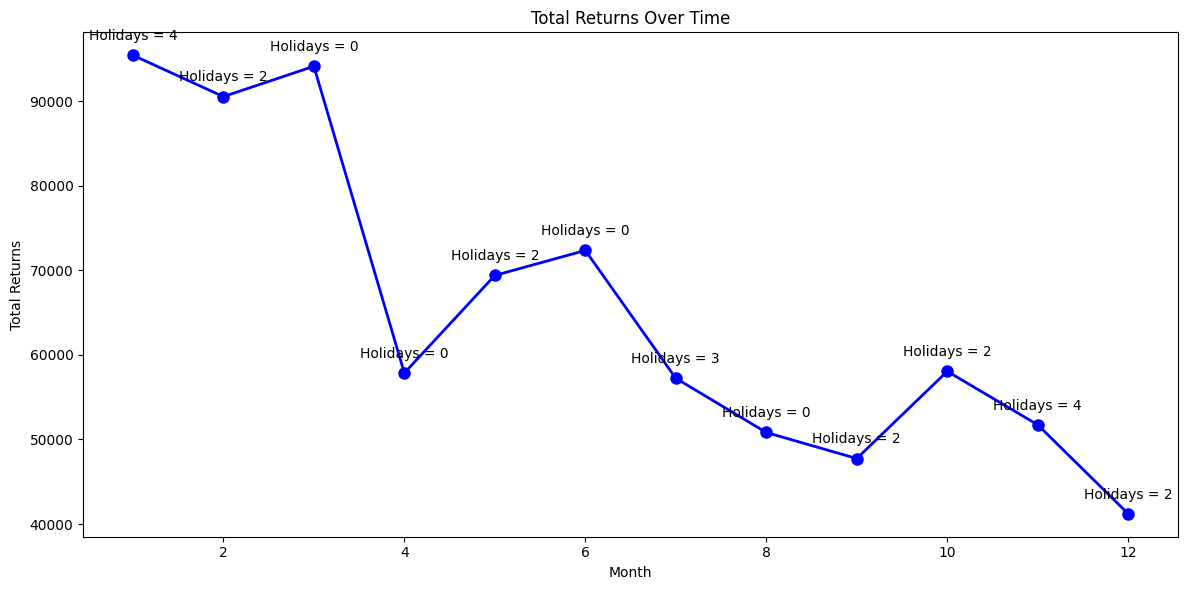

In [ ]:
column_names = ["orderID", "orderDate", "articleID", "colorCode", "sizeCode", "productGroup", "quantity", "price", "rrp", "voucherID", "voucherAmount", "customerID", "deviceID", "paymentMethod", "returnQuantity"]
df = pd.read_csv("orders_train.txt", delimiter=";", names=column_names, skiprows=1)
df['orderDate'] = pd.to_datetime(df['orderDate'])
df['orderMonth'] = df['orderDate'].dt.month
monthly_returns = df.groupby('orderMonth')['returnQuantity'].sum()

plt.figure(figsize=(12, 6))
monthly_returns.plot(marker='o', color='blue', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Month')
plt.ylabel('Total Returns')
plt.title('Total Returns Over Time')

us_holidays = holidays.US(years=df['orderDate'].dt.year.unique())
holidays_in_months = {month: sum(1 for day in us_holidays if day.month == month) for month in range(1, 13)}

for month, holidays_count in holidays_in_months.items():
    if month in monthly_returns.index:
        plt.text(month, monthly_returns[month] + 1800, f'Holidays = {holidays_count}', color='black', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


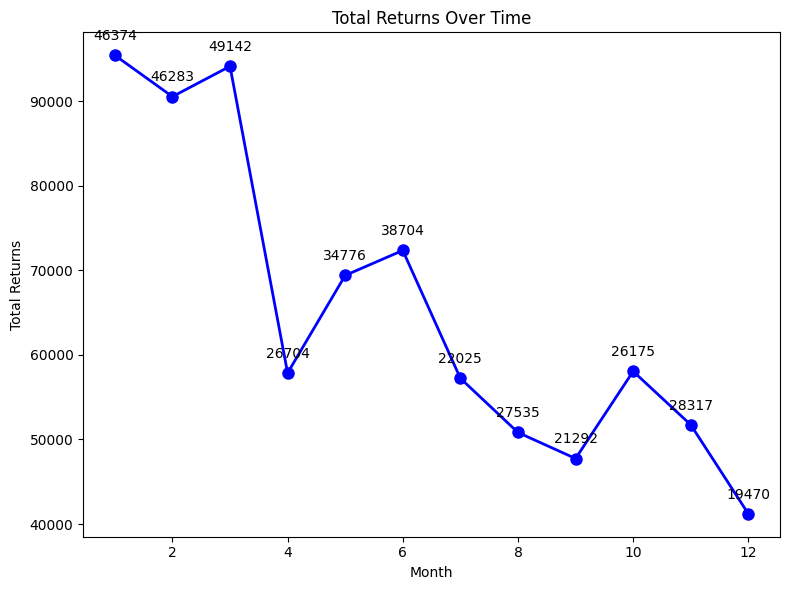

In [ ]:
# Group by orderMonth and sum returnQuantity
monthly_returns = df.groupby('orderMonth')['returnQuantity'].sum()

# Plot total returns over time
plt.figure(figsize=(8, 6))
monthly_returns.plot(marker='o', color='blue', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Month')
plt.ylabel('Total Returns')
plt.title('Total Returns Over Time')
us_holidays = holidays.US(years=df['orderDate'].dt.year.unique())
weekend_holidays = [day for day in df['orderDate'] if day.dayofweek in [5, 6]]  # Saturday and Sunday
holidays_in_months = {month: sum(1 for day in us_holidays if day.month == month) + sum(1 for day in weekend_holidays if day.month == month) for month in range(1, 13)}
for month, holidays_count in holidays_in_months.items():
    plt.text(month, monthly_returns[month] + 1800, f'{holidays_count}', color='black', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('weekends_plus_holidays.png',dpi=200)


#### Temporal analysis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

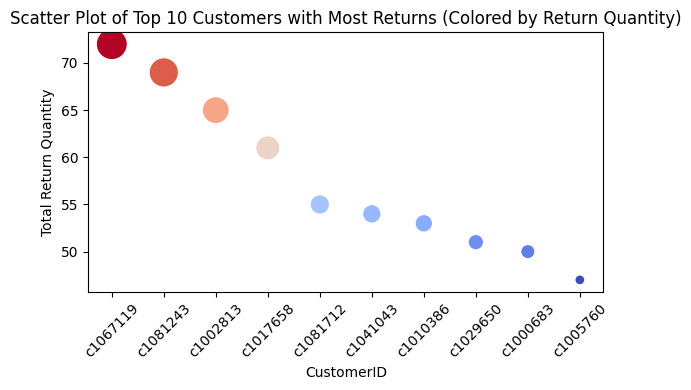

In [ ]:
df = data.copy()
most_returns = df.groupby('customerID')['returnQuantity'].sum().nlargest(10)
plt.figure(figsize=(6, 4))
# Create a scatter plot with hues based on return quantity
sns.scatterplot(x=most_returns.index, y=most_returns.values, size=most_returns.values,
                sizes=(50, 500), hue=most_returns.values, palette='coolwarm', legend=False)
plt.xticks(rotation=45)
plt.xlabel('CustomerID')
plt.ylabel('Total Return Quantity')
plt.title('Scatter Plot of Top 10 Customers with Most Returns (Colored by Return Quantity)')

plt.tight_layout()
plt.show()
#plt.savefig('customers_with_most_retruns.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/c_parser_wrapper.py:373: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common_type = np.find_common_type(
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common

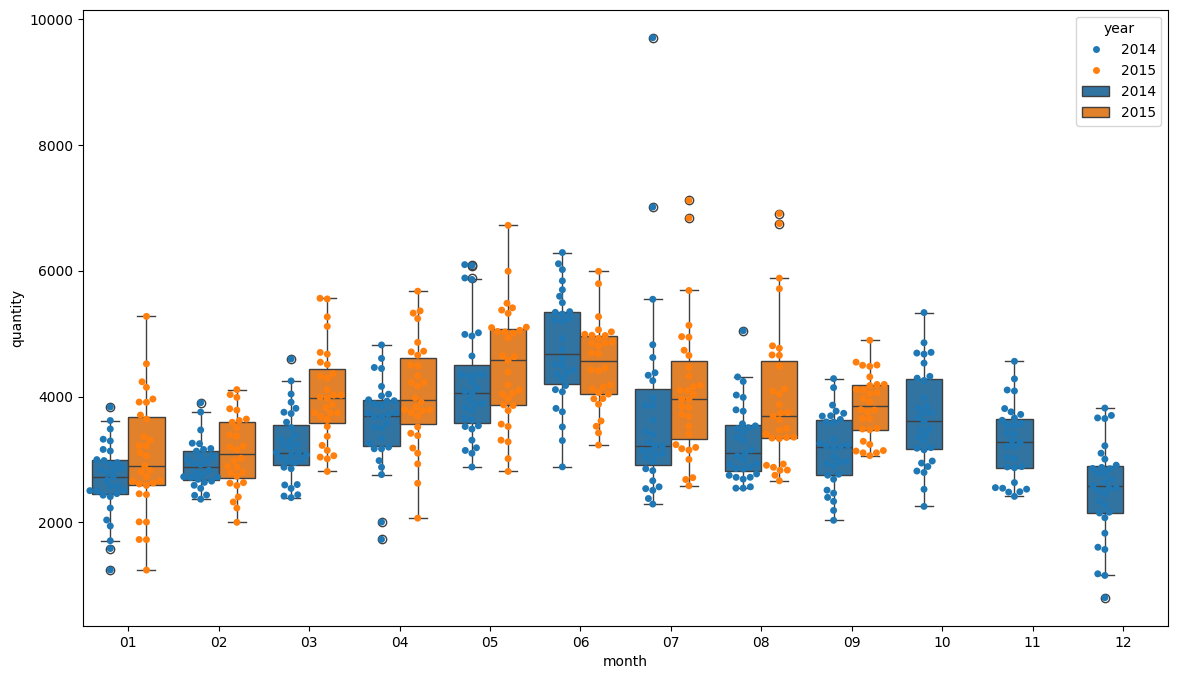

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (D

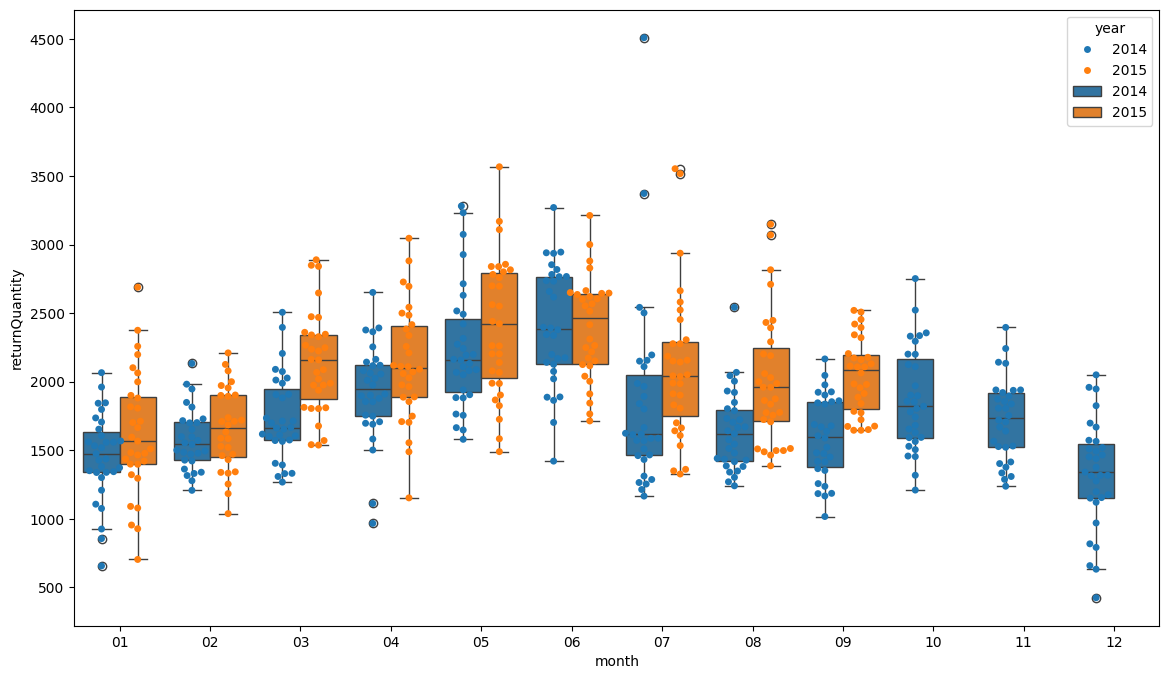

In [ ]:
# make new columns for year, month and day
data = pd.read_csv('orders_train.txt', sep=';')
data[['year', 'month', 'day']] = data['orderDate'].str.split('-', expand=True)
monthlySale = data.groupby(['month', 'day', 'year'])['quantity'].sum().reset_index()
monthlyReturn = data.groupby(['month', 'day', 'year'])['returnQuantity'].sum().reset_index()
# visualize montly sale and return for 2014 and 2015
plt.figure(figsize=(14, 8))
sns.swarmplot(x='month', y='quantity', data=monthlySale, hue = 'year', dodge=True)
sns.boxplot(x='month', y='quantity', data=monthlySale, hue = 'year', dodge=True)
plt.show()

plt.figure(figsize=(14, 8))
sns.swarmplot(x='month', y='returnQuantity', data=monthlyReturn, hue = 'year', dodge=True)
sns.boxplot(x='month', y='returnQuantity', data=monthlyReturn, hue = 'year')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

Text(0, 0.5, 'Average discount (%)')

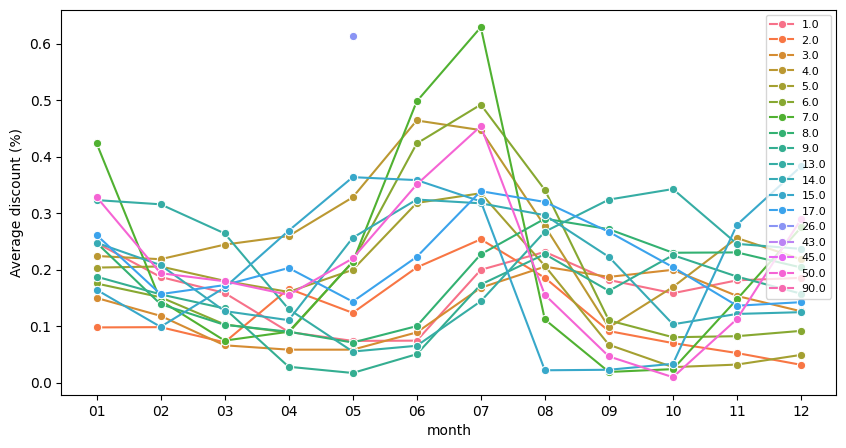

In [ ]:
# visualizing the average discounts for different product groups in each month
data['discountRatio'] = (data['rrp']-data['price']/data['quantity'])/data['rrp']
discount = data.groupby(['productGroup', 'month'])['discountRatio'].mean().reset_index()
plt.figure(figsize= (10,5))
sns.lineplot(data= discount, x ='month', y ='discountRatio', hue=discount['productGroup'].astype(str), marker='o')
plt.legend(fontsize=8)
plt.ylabel('Average discount (%)')

#### Product characteristics- Sizes offered by the retailer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

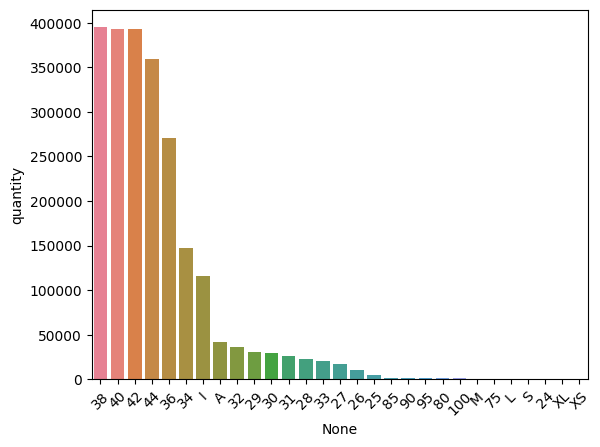

In [ ]:
sizes = data['sizeCode'].value_counts()
sns.barplot(x= sizes.index, y=sizes.values, hue = sizes.index)
plt.xticks(rotation=45)
plt.ylabel('quantity')
plt.show()

In [ ]:
# dropping sizes A and I for now...
data = data[~data['sizeCode'].isin(['A', 'I'])]
# sizes bought by unique customers
custm_size = data.groupby('customerID')['sizeCode'].agg(list).reset_index()
custm_size['sizeCode'] = custm_size['sizeCode'].apply(lambda x: list(set(x)))
custm_size

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


,customerID,sizeCode
0,c1000001,"[40, 42, 36, 90, 38, 29, L]"
1,c1000002,"[36, 34, 27, 38]"
2,c1000003,[34]
3,c1000004,[36]
4,c1000005,"[42, 40, 38, 29]"
...,...,...
306950,c1319615,[40]
306951,c1319850,[42]
306952,c1320021,[28]
306953,c1320568,[36]


In [ ]:
#encode the data
encoder = TransactionEncoder() #initialize the encoder
ecd_data = encoder.fit(custm_size['sizeCode']).transform(custm_size['sizeCode'])# encoded data

# make dataframe of encoded data
ecd_df = pd.DataFrame(ecd_data, columns=encoder.columns_)
FP = apriori(ecd_df, min_support= 0.00005, use_colnames=True, max_len = 2)
rules = association_rules(FP, metric='confidence', min_threshold= 0.001)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules['antecedents'] = list(map(lambda x: list(x)[0], rules['antecedents']))
rules['consequents'] = list(map(lambda x: list(x)[0], rules['consequents']))
bold = "\033[1m"
reset = "\033[0m"
print(bold+'Mapping of other units of sizes to standard sizes between 34 - 44:\n'+reset)
print(bold+'other unit\t standard unit \t confidence'+reset)
for size in ['75', '80', '85', '90', '95', '100', 'XS', 'S', 'M', 'L', 'XL', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33']:
    idx = [rules[rules['antecedents'] == size]['confidence'].idxmax()]
    print(rules.iloc[idx]['antecedents'].to_string(index=False), '\t\t', rules.iloc[idx]['consequents'].to_string(index=False),
          '\t\t', rules.iloc[idx]['confidence'].to_string(index=False))


Mapping of other units of sizes to standard sizes between 34 - 44:

other unit	 standard unit 	 confidence
75 		 34 		 0.695876
80 		 36 		 0.691713
85 		 38 		 0.662013
90 		 38 		 0.649477
95 		 40 		 0.679315
100 		 42 		 0.701124
XS 		 34 		 0.625
S 		 36 		 0.64
M 		 38 		 0.626822
L 		 42 		 0.653488
XL 		 42 		 0.702703
24 		 34 		 0.688259
25 		 34 		 0.607399
26 		 36 		 0.612545
27 		 36 		 0.601883
28 		 38 		 0.601
29 		 38 		 0.616744
30 		 40 		 0.609986
31 		 40 		 0.589032
32 		 42 		 0.493127
33 		 42 		 0.636126


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

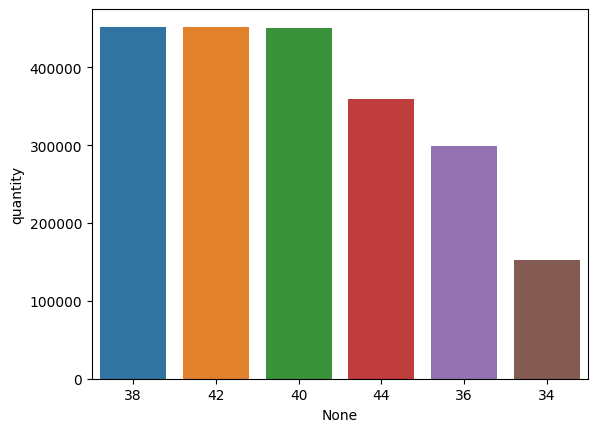

In [ ]:
mapping = {'75':'34', '80': '36', '85': '38', '90': '38', '95': '40', '100': '42', 'XS':'34', 'S': '36',  'M': '38','L':'42',
'XL':'42', '24':'34', '25':'34' , '26':'36', '27':'36', '28':'38','29': '38','30':'40','31':'40','32':'42', '33':'42'}
for key in mapping.keys():
    idx = data['sizeCode']==key
    data.loc[idx, 'sizeCode'] = mapping[key]
# new size distribution after mapping different sizes into standard sizes
sizes = data['sizeCode'].value_counts()
sns.barplot(x= sizes.index, y=sizes.values, hue=sizes.index)
plt.ylabel('quantity')
plt.show()

#### Buying and return behavior of customers w.r.t. product characterictics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


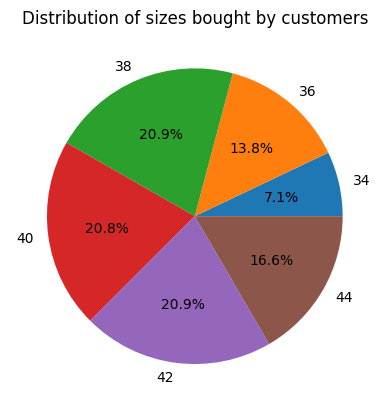

In [ ]:
#visualize the sizes that are most often bought
sizes_bought = data.groupby('sizeCode')['quantity'].apply(lambda x: sum(list(x))).reset_index()
sizes_bought['%'] = sizes_bought['quantity']/data['quantity'].sum()
plt.pie(x = sizes_bought['%'], labels = sizes_bought['sizeCode'], autopct='%1.1f%%')
plt.title('Distribution of sizes bought by customers')
plt.show()
del sizes_bought

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


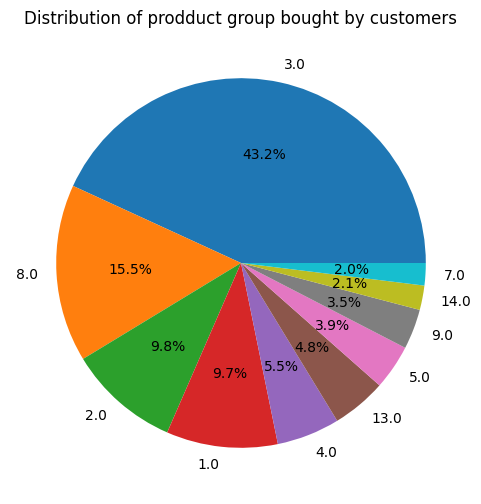

In [ ]:
#visualize the product group that are most often bought
category_bought = data.groupby('productGroup')['quantity'].apply(lambda x: sum(list(x))).reset_index()
category_bought['%'] = category_bought['quantity']/data['quantity'].sum()
category_bought = category_bought.sort_values(by = '%', ascending = False).iloc[0:10]
plt.figure(figsize=(6,6))
plt.pie(x = category_bought['%'], labels = category_bought['productGroup'], autopct='%1.1f%%')
plt.title('Distribution of prodduct group bought by customers')
plt.show()
del category_bought

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total number of unique color codes: 537


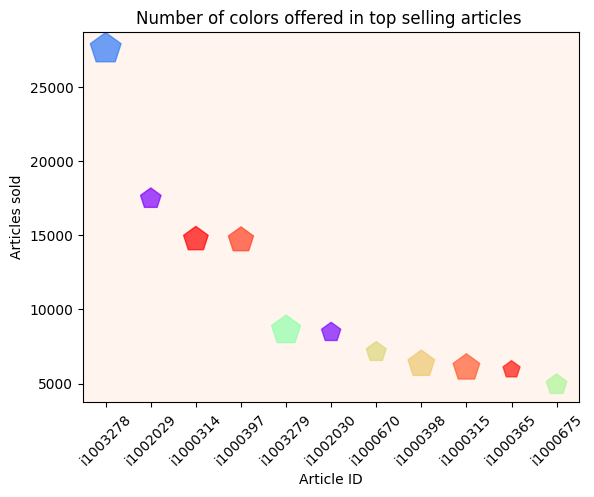

,articleID,quantity,uniqueColorCodes
0,i1003278,27611,36
1,i1002029,17482,16
2,i1000314,14741,23
3,i1000397,14687,24
4,i1003279,8594,32
5,i1002030,8455,14
6,i1000670,7128,15
7,i1000398,6312,27
8,i1000315,6065,27
9,i1000365,5939,11


In [ ]:
# colors offered in top selling items
print('Total number of unique color codes:', data['colorCode'].nunique())
colorcode = data.groupby('articleID')['quantity'].sum().sort_values(ascending= False).reset_index().head(20)\
.merge(data.groupby('articleID')['colorCode'].nunique().sort_values(ascending= False).reset_index().rename(columns={'colorCode': 'uniqueColorCodes'}).head(20), on ='articleID')

plt.scatter(x=colorcode['articleID'], y = colorcode['quantity'], s = 15*colorcode['uniqueColorCodes'], c = np.random.rand(len(colorcode)), \
            marker='p', alpha=0.7, cmap  = plt.get_cmap("rainbow"))
plt.ylabel('Articles sold')
plt.xlabel('Article ID')
plt.title('Number of colors offered in top selling articles ')
plt.gca().set_facecolor(color='seashell')
plt.xticks(rotation=45)
plt.show()

colorcode

#### Distribution of number of items in an order

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


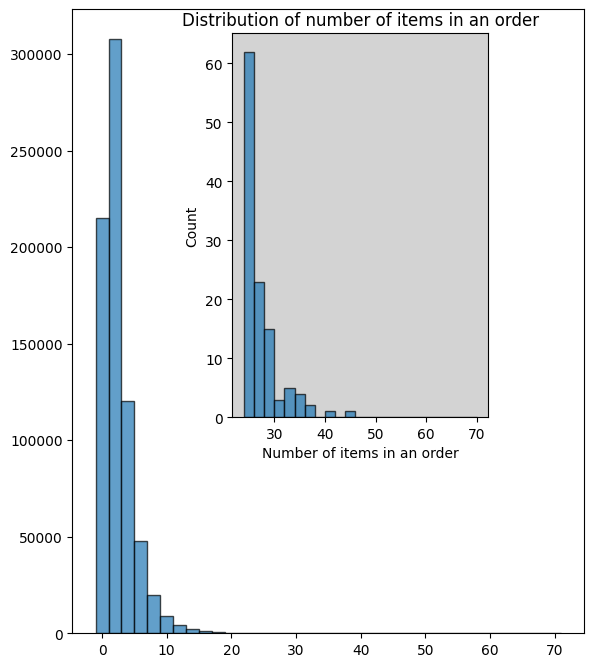

In [ ]:
uniqueOrders = data.groupby('orderID')[['quantity', 'returnQuantity']].sum().reset_index()
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 1.3])
axes2 = fig.add_axes([0.35, 0.55, 0.4, 0.8])
axes.hist(uniqueOrders['quantity'], bins=range(0, max(uniqueOrders['quantity']), 2), align='left', edgecolor='black', alpha=0.7)
axes2.hist(uniqueOrders['quantity'], bins=range(25, max(uniqueOrders['quantity']), 2), align='left', edgecolor='black', alpha=0.7)
axes2.set_facecolor('lightgray')
plt.xlabel('Number of items in an order')
plt.ylabel('Count')
plt.title('Distribution of number of items in an order')
fig.show()


In [ ]:
#add a binary return variable
data['bin_return'] = data['returnQuantity'].apply(lambda x: int(x!=0))
data.loc[data['returnQuantity']>1].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,orderID,orderDate,articleID,colorCode,sizeCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,deviceID,paymentMethod,returnQuantity,year,month,day,discountRatio,bin_return
958,a1000321,2014-01-01,i1000314,1493,40,3.0,2,45.98,22.99,0,0.0,c1089417,2,BPRG,2,2014,01,01,0.0,1
1056,a1000350,2014-01-01,i1000312,1000,44,3.0,2,35.98,17.99,0,0.0,c1022255,3,BPRG,2,2014,01,01,0.0,1
1057,a1000350,2014-01-01,i1000325,1000,44,3.0,2,39.98,19.99,0,0.0,c1022255,3,BPRG,2,2014,01,01,0.0,1
1058,a1000350,2014-01-01,i1000663,1000,44,3.0,2,35.98,17.99,0,0.0,c1022255,3,BPRG,2,2014,01,01,0.0,1
1396,a1000450,2014-01-02,i1000326,1961,42,3.0,2,39.98,19.99,0,0.0,c1089473,2,CBA,2,2014,01,02,0.0,1


# Making the "order_df" dataframe

In [ ]:
def list_items(vec):
    lst = []
    for item in vec:
        lst.append(item)
    return lst

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
uniq_order_df = data.groupby('orderID', as_index=False).agg({'orderDate': list_items,
                                                            'articleID': list_items,
                                                            'colorCode': list_items,
                                                            'productGroup': list_items,
                                                            'quantity': np.sum,
                                                            'price': np.sum,
                                                            'rrp': np.sum,
                                                            'voucherID': list_items,
                                                            'voucherAmount': list_items,
                                                            'customerID': list_items,
                                                            'paymentMethod': list_items,
                                                            'returnQuantity': np.sum})
uniq_order_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,orderID,orderDate,articleID,colorCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,paymentMethod,returnQuantity
0,a1000001,"[2014-01-01, 2014-01-01]","[i1000382, i1000550]","[1972, 3854]","[3.0, 3.0]",2,30.00,69.98,"[0, 0]","[0.0, 0.0]","[c1010575, c1010575]","[BPRG, BPRG]",0
1,a1000002,"[2014-01-01, 2014-01-01]","[i1001991, i1001999]","[2974, 1992]","[8.0, 8.0]",2,84.99,99.98,"[0, 0]","[0.0, 0.0]","[c1045905, c1045905]","[BPRG, BPRG]",1
2,a1000003,"[2014-01-01, 2014-01-01, 2014-01-01, 2014-01-0...","[i1001942, i1001942, i1001974, i1001976, i1002...","[1968, 1972, 1001, 3976, 2493]","[8.0, 8.0, 8.0, 8.0, 13.0]",4,60.00,211.95,"[0, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[c1089295, c1089295, c1089295, c1089295, c1089...","[PAYPALVC, PAYPALVC, PAYPALVC, PAYPALVC, PAYPA...",0
3,a1000004,[2014-01-01],[i1002457],[1001],[14.0],1,89.99,89.99,[0],[0.0],[c1050116],[BPRG],1
4,a1000005,"[2014-01-01, 2014-01-01, 2014-01-01]","[i1000366, i1000406, i1000406]","[1968, 3972, 3972]","[3.0, 3.0, 3.0]",3,35.00,99.97,"[0, 0, 0]","[0.0, 0.0, 0.0]","[c1089296, c1089296, c1089296]","[BPRG, BPRG, BPRG]",3


In [ ]:
# check if all the lists are homogeneous (all elements are equal)
def homogeneous(lst):
    first = lst[0]
    for item in lst:
        if item != first:
            return 0
    return 1

num = 1
list_columns = uniq_order_df[['orderDate', 'voucherID', 'voucherAmount', 'customerID', 'paymentMethod']]
for i in range(list_columns.shape[0]):
    row = list_columns.iloc[i]
    for col in row.values:
        num *= homogeneous(col)

print(num)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0


Since `num`=1, we know that all these lists are homogeneous, thus we do not need to store these row values as lists, rather we can store them as strings. Thus, we make a new dataframe.

In [ ]:
uniq_order_df2 = data.groupby('orderID', as_index=False).agg({'orderDate': 'first',
                                                            'articleID': list,
                                                            'colorCode': list,
                                                            'productGroup': list,
                                                            'quantity': np.sum,
                                                            'price': np.sum,
                                                            'rrp': np.sum,
                                                            'voucherID': 'first',
                                                            'voucherAmount': 'first',
                                                            'customerID': 'first',
                                                            'paymentMethod': 'first',
                                                            'returnQuantity': np.sum})
uniq_order_df2.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,orderID,orderDate,articleID,colorCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,paymentMethod,returnQuantity
0,a1000001,2014-01-01,"[i1000382, i1000550]","[1972, 3854]","[3.0, 3.0]",2,30.00,69.98,0,0.0,c1010575,BPRG,0
1,a1000002,2014-01-01,"[i1001991, i1001999]","[2974, 1992]","[8.0, 8.0]",2,84.99,99.98,0,0.0,c1045905,BPRG,1
2,a1000003,2014-01-01,"[i1001942, i1001942, i1001974, i1001976, i1002...","[1968, 1972, 1001, 3976, 2493]","[8.0, 8.0, 8.0, 8.0, 13.0]",4,60.00,211.95,0,0.0,c1089295,PAYPALVC,0
3,a1000004,2014-01-01,[i1002457],[1001],[14.0],1,89.99,89.99,0,0.0,c1050116,BPRG,1
4,a1000005,2014-01-01,"[i1000366, i1000406, i1000406]","[1968, 3972, 3972]","[3.0, 3.0, 3.0]",3,35.00,99.97,0,0.0,c1089296,BPRG,3


In [ ]:
#add a binary return variable
uniq_order_df2['bin_return'] = uniq_order_df2['returnQuantity'].apply(lambda x: int(x!=0))
uniq_order_df2.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,orderID,orderDate,articleID,colorCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,paymentMethod,returnQuantity,bin_return
0,a1000001,2014-01-01,"[i1000382, i1000550]","[1972, 3854]","[3.0, 3.0]",2,30.00,69.98,0,0.0,c1010575,BPRG,0,0
1,a1000002,2014-01-01,"[i1001991, i1001999]","[2974, 1992]","[8.0, 8.0]",2,84.99,99.98,0,0.0,c1045905,BPRG,1,1
2,a1000003,2014-01-01,"[i1001942, i1001942, i1001974, i1001976, i1002...","[1968, 1972, 1001, 3976, 2493]","[8.0, 8.0, 8.0, 8.0, 13.0]",4,60.00,211.95,0,0.0,c1089295,PAYPALVC,0,0
3,a1000004,2014-01-01,[i1002457],[1001],[14.0],1,89.99,89.99,0,0.0,c1050116,BPRG,1,1
4,a1000005,2014-01-01,"[i1000366, i1000406, i1000406]","[1968, 3972, 3972]","[3.0, 3.0, 3.0]",3,35.00,99.97,0,0.0,c1089296,BPRG,3,1


In [ ]:
# make a copy and save as a csv
order_df = uniq_order_df2.copy()
# order_df.to_csv('fashion_train_order_df.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
order_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,orderID,orderDate,articleID,colorCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,paymentMethod,returnQuantity,bin_return
0,a1000001,2014-01-01,"[i1000382, i1000550]","[1972, 3854]","[3.0, 3.0]",2,30.00,69.98,0,0.0,c1010575,BPRG,0,0
1,a1000002,2014-01-01,"[i1001991, i1001999]","[2974, 1992]","[8.0, 8.0]",2,84.99,99.98,0,0.0,c1045905,BPRG,1,1
2,a1000003,2014-01-01,"[i1001942, i1001942, i1001974, i1001976, i1002...","[1968, 1972, 1001, 3976, 2493]","[8.0, 8.0, 8.0, 8.0, 13.0]",4,60.00,211.95,0,0.0,c1089295,PAYPALVC,0,0
3,a1000004,2014-01-01,[i1002457],[1001],[14.0],1,89.99,89.99,0,0.0,c1050116,BPRG,1,1
4,a1000005,2014-01-01,"[i1000366, i1000406, i1000406]","[1968, 3972, 3972]","[3.0, 3.0, 3.0]",3,35.00,99.97,0,0.0,c1089296,BPRG,3,1


In [ ]:
order_df.info()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728329 entries, 0 to 728328
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   orderID         728329 non-null  object 
 1   orderDate       728329 non-null  object 
 2   articleID       728329 non-null  object 
 3   colorCode       728329 non-null  object 
 4   productGroup    728329 non-null  object 
 5   quantity        728329 non-null  int64  
 6   price           728329 non-null  float64
 7   rrp             728329 non-null  float64
 8   voucherID       728328 non-null  object 
 9   voucherAmount   728329 non-null  float64
 10  customerID      728329 non-null  object 
 11  paymentMethod   728329 non-null  object 
 12  returnQuantity  728329 non-null  int64  
 13  bin_return      728329 non-null  int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 77.8+ MB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


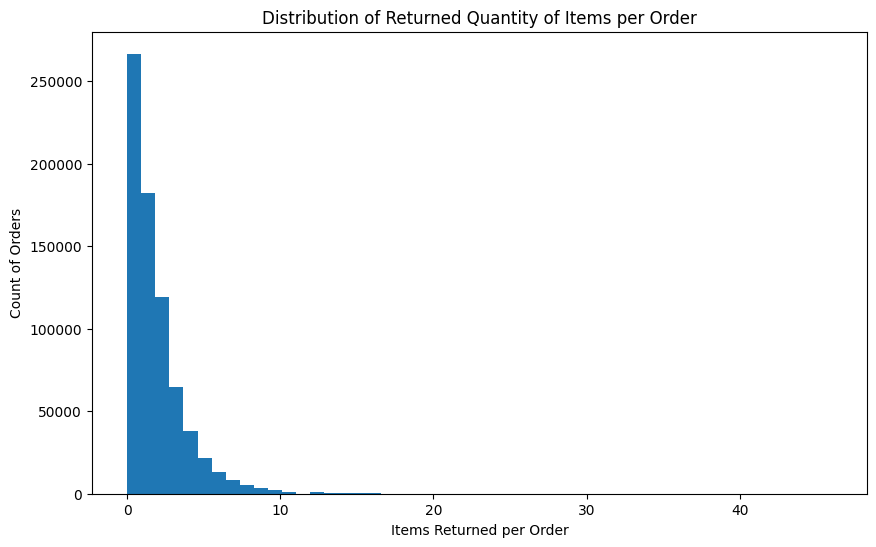

In [ ]:
# plotting the distribution of returned quantity of items
plt.figure(figsize=(10,6))
order_df['returnQuantity'].plot.hist(bins=50)
plt.title('Distribution of Returned Quantity of Items per Order')
plt.xlabel('Items Returned per Order')
plt.ylabel('Count of Orders')
plt.show()

# Making the "customers_df"

In [ ]:
order_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,orderID,orderDate,articleID,colorCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,paymentMethod,returnQuantity,bin_return
0,a1000001,2014-01-01,"[i1000382, i1000550]","[1972, 3854]","[3.0, 3.0]",2,30.00,69.98,0,0.0,c1010575,BPRG,0,0
1,a1000002,2014-01-01,"[i1001991, i1001999]","[2974, 1992]","[8.0, 8.0]",2,84.99,99.98,0,0.0,c1045905,BPRG,1,1
2,a1000003,2014-01-01,"[i1001942, i1001942, i1001974, i1001976, i1002...","[1968, 1972, 1001, 3976, 2493]","[8.0, 8.0, 8.0, 8.0, 13.0]",4,60.00,211.95,0,0.0,c1089295,PAYPALVC,0,0
3,a1000004,2014-01-01,[i1002457],[1001],[14.0],1,89.99,89.99,0,0.0,c1050116,BPRG,1,1
4,a1000005,2014-01-01,"[i1000366, i1000406, i1000406]","[1968, 3972, 3972]","[3.0, 3.0, 3.0]",3,35.00,99.97,0,0.0,c1089296,BPRG,3,1


In [ ]:
def unique_count(vec):
    sett = set()
    for elt in vec:
        sett.add(elt)
    return len(sett)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
customers_df = order_df.groupby(by='customerID', as_index=False).agg({'orderID': unique_count,
                                                                    'orderDate': list,
                                                                    'articleID': list,
                                                                    'colorCode': list,
                                                                    'productGroup': list,
                                                                    'quantity': np.sum,
                                                                    'price': np.sum,
                                                                    'rrp': np.sum,
                                                                    'voucherID': list,
                                                                    'voucherAmount': np.sum,
                                                                    'paymentMethod': list,
                                                                    'returnQuantity': np.sum,
                                                                    'bin_return': np.sum})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
customers_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customerID,orderID,orderDate,articleID,colorCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,paymentMethod,returnQuantity,bin_return
0,c1000001,76,"[2014-01-15, 2014-01-16, 2014-01-24, 2014-01-2...","[[i1001229], [i1002531, i1002531], [i1000357],...","[[1993], [1995, 1999], [2996], [1993], [3002, ...","[[4.0], [15.0, 15.0], [3.0], [5.0], [3.0, 4.0,...",126,3985.91,4030.90,"[0, 0, v1000086, 0, v1000111, 0, v1000129, 0, ...",20.0,"[BPRG, BPRG, BPRG, BPRG, BPRG, BPRG, BPRG, BPR...",75,55
1,c1000002,8,"[2014-01-11, 2014-01-22, 2014-01-30, 2014-02-1...","[[i1002442], [i1002025, i1002025, i1002025, i1...","[[1001], [1493, 1493, 1999, 1999], [1953], [19...","[[14.0], [8.0, 8.0, 8.0, 8.0], [7.0], [7.0], [...",11,783.90,818.90,"[0, 0, 0, 0, 0, 0, 0, 0]",0.0,"[BPRG, BPRG, BPRG, BPRG, BPRG, BPRG, BPRG, BPRG]",10,7
2,c1000003,1,[2014-10-29],"[[i1001267, i1001274]]","[[2001, 1014]]","[[4.0, 4.0]]",2,109.99,129.98,[v1000278],10.0,[BPRG],1,1
3,c1000004,3,"[2014-05-25, 2015-07-12, 2015-07-15]","[[i1000860, i1000860], [i1001699], [i1000450, ...","[[1000, 1012], [3093], [1055, 1085, 1089, 3096...","[[3.0, 3.0], [8.0], [3.0, 3.0, 5.0, 8.0, 8.0]]",8,251.92,251.92,"[0, 0, v1000731]",0.0,"[BPRG, BPRG, BPRG]",4,3
4,c1000005,24,"[2014-01-16, 2014-02-13, 2014-02-20, 2014-02-2...","[[i1001175, i1001175, i1001210, i1001229, i100...","[[2001, 2953, 1993, 1993, 3927, 1953, 1953], [...","[[4.0, 4.0, 4.0, 4.0, 5.0, 6.0, 6.0], [1.0, 1....",80,3394.34,3767.19,"[0, 0, v1000129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",30.0,"[BPRG, BPRG, BPRG, BPRG, BPRG, BPRG, BPRG, BPR...",56,18


In [ ]:
# rename columns
customers_df.rename(columns={'orderID':'totalOrders', 'quantity':'totalItemsPurchased',
                            'price':'totalDollarsPaid', 'rrp':'totalRRP', 'voucherAmount':'totalVoucherValue',
                            'returnQuantity':'totalItemsReturned', 'bin_return':'totalOrdersWithReturn'}, inplace = True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
customers_df.head()

In [ ]:
customers_df.info()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306955 entries, 0 to 306954
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   customerID             306955 non-null  object 
 1   totalOrders            306955 non-null  int64  
 2   orderDate              306955 non-null  object 
 3   articleID              306955 non-null  object 
 4   colorCode              306955 non-null  object 
 5   productGroup           306955 non-null  object 
 6   totalItemsPurchased    306955 non-null  int64  
 7   totalDollarsPaid       306955 non-null  float64
 8   totalRRP               306955 non-null  float64
 9   voucherID              306955 non-null  object 
 10  totalVoucherValue      306955 non-null  float64
 11  paymentMethod          306955 non-null  object 
 12  totalItemsReturned     306955 non-null  int64  
 13  totalOrdersWithReturn  306955 non-null  int64  
dtypes: float64(3), int64(4), object(7)
m

In [ ]:
# save as a csv
# customers_df.to_csv('fashion_train_customers_df.csv')

## Finding Test Statistics

### Does payment method influence return probability?

In [ ]:
paymentMethod_count = order_df.groupby(by='paymentMethod')['orderID'].count()
paymentMethod_count

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


paymentMethod
BPLS          4491
BPPL           801
BPRG        545807
CBA          68167
KGRG            91
KKE          32015
NN            7589
PAYPALVC     59766
RG               2
VORAUS        9600
Name: orderID, dtype: int64

In [ ]:
returns_by_paymentMethod = order_df.groupby(by='paymentMethod')['bin_return'].sum()
returns_by_paymentMethod

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


paymentMethod
BPLS          1899
BPPL           540
BPRG        375781
CBA          30839
KGRG            32
KKE          17834
NN            2882
PAYPALVC     27799
RG               0
VORAUS        4226
Name: bin_return, dtype: int64

In [ ]:
avg_returns_by_PM = returns_by_paymentMethod/paymentMethod_count
avg_returns_by_PM

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


paymentMethod
BPLS        0.422846
BPPL        0.674157
BPRG        0.688487
CBA         0.452404
KGRG        0.351648
KKE         0.557051
NN          0.379760
PAYPALVC    0.465131
RG          0.000000
VORAUS      0.440208
dtype: float64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


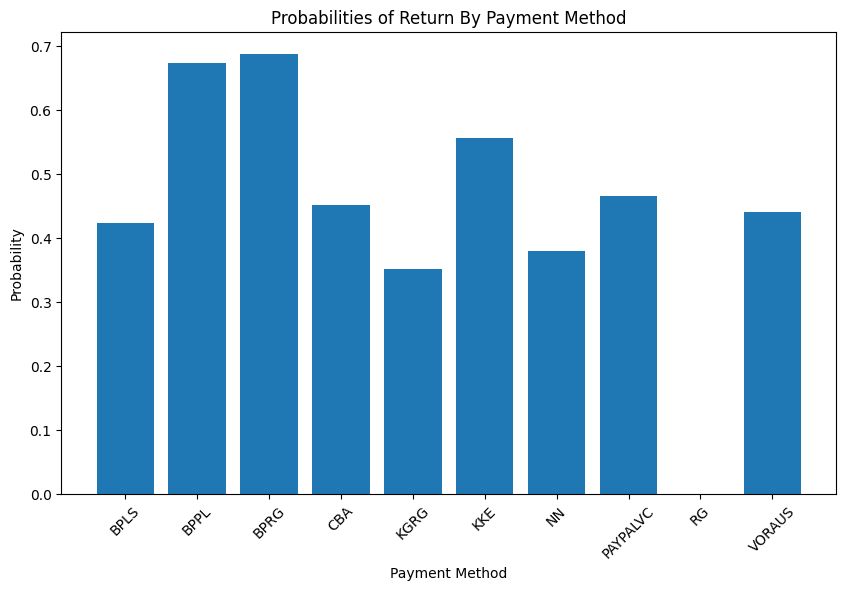

In [ ]:
# plotting
plt.figure(figsize=(10,6))
x = avg_returns_by_PM.index
y = avg_returns_by_PM.values
plt.xticks(rotation=45)
plt.bar(x,y)
plt.title('Probabilities of Return By Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Probability')
plt.show()

### Are orders that use vouchers more or less likely to be returned?

In [ ]:
orders_used_voucher_count = order_df.loc[(order_df['voucherAmount']!=0)]['orderID'].count()
orders_no_voucher_count = order_df.loc[(order_df['voucherAmount']==0)]['orderID'].count()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
voucher_returns = order_df.loc[(order_df['voucherAmount']!=0)]['bin_return'].sum()
other_returns = order_df.loc[(order_df['voucherAmount']==0)]['bin_return'].sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
x1 = voucher_returns/orders_used_voucher_count
x2 = other_returns/orders_no_voucher_count

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


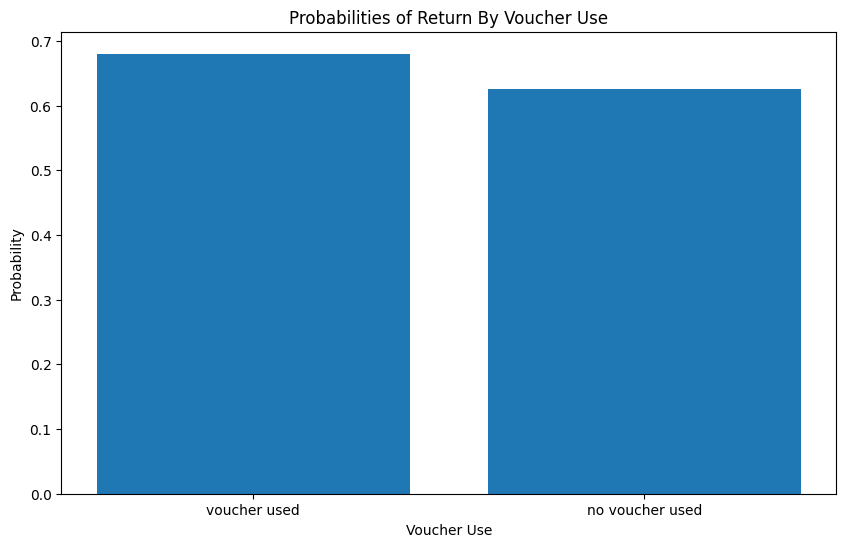

In [ ]:
# plotting
plt.figure(figsize=(10,6))
plt.bar(['voucher used', 'no voucher used'], [x1,x2])
plt.title('Probabilities of Return By Voucher Use')
plt.xlabel('Voucher Use')
plt.ylabel('Probability')
plt.show()

### Are orders of lower quantities more or less likely to be returned?


In [ ]:
# how many orders of each quantity were made
quantity_count = order_df.groupby(by='quantity')['orderID'].count()
# quantity_count

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# how many orders of each quantity had at least one returned item
count_returns_by_quant = uniq_order_df2.groupby(by='quantity')['bin_return'].sum()
# count_returns_by_quant

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# orders with at least one return / total number of orders
avg_returns_by_quant = count_returns_by_quant/quantity_count
# avg_returns_by_quant

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


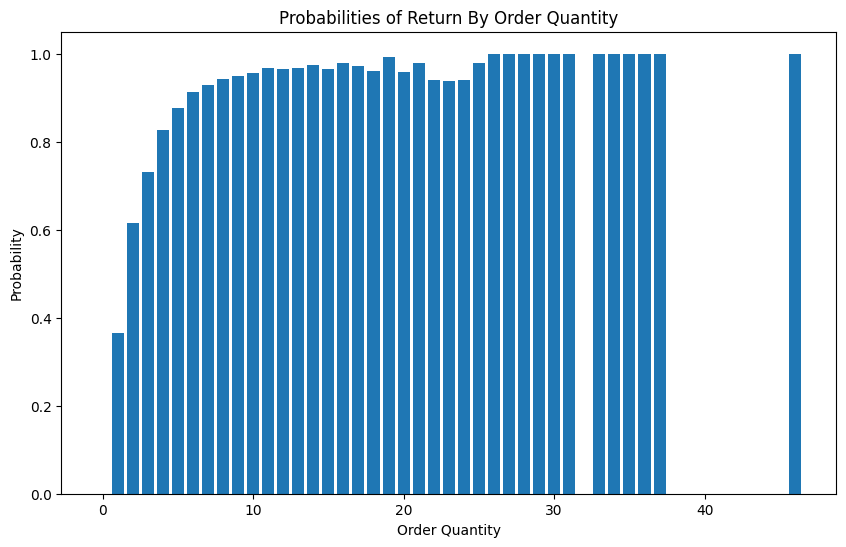

In [ ]:
plt.figure(figsize=(10,6))
x = avg_returns_by_quant.index[:-1]
y = avg_returns_by_quant.values[:-1]
plt.bar(x,y)
plt.title('Probabilities of Return By Order Quantity')
plt.xlabel('Order Quantity')
plt.ylabel('Probability')
plt.show()